### Classification
In very few words: classification is like regression but with a categorical response. As before there will be a learning function $f(\bf x,\beta)$ but now the model that relates it to the response has to change to reflect the different characteristics of our $y$ variable. But we can use the same set of tools - loss functions will change and as a result our tools for measuring performance too. 

This is a very common prediction problem and it is worth to understand some of its intricacies. We will start with binary classification - the response is one of two categories. The labelling of the categories is arbitrary and any sensible methodology should not rely on how these categories are coded numerically. We will stick to 0/1 coding for the two categories. This is mathematically more convenient for the methods we will use here. 


### Summary

In this module we build predictive models for categorical outputs, following the same paradigm as in regression. We also adapt appropriately the model performance criteria and introduce concepts such as the misclassification probability, the ROC curve and AUC score. We discuss the problem of class imbalance and some solutions. We show how to predict multicategorical and ordinal output in a simple framework.

### The spam dataset

This is a classic dataset for binary classification, it can be found in the UCI repository

https://archive.ics.uci.edu/ml/datasets/spambase

and it is analyzed in few different ways in the Hastie et al. book 

We will use a subset of this data. Our objective is to identify a message as an _email_ or _spam_ on the basis of word and character frequencies for each messages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import numpy as np

In [3]:
spam = pd.read_csv("https://github.com/barcelonagse-datascience/academic_files/raw/master/data/spam_small_train.csv")
print(spam.shape)
spam.head()

(2686, 12)


,word_freq_george,word_freq_you,word_freq_your,word_freq_hp,word_freq_free,word_freq_hpl,word_freq_our,word_freq_re,word_freq_edu,word_freq_remove,char_freq_!,class
0,0.0,1.93,0.96,0.0,0.32,0.0,0.32,0.00,0.00,0.00,0.778,1
1,0.0,3.47,1.59,0.0,0.14,0.0,0.14,0.00,0.00,0.21,0.372,1
2,0.0,1.36,0.51,0.0,0.06,0.0,1.23,0.06,0.06,0.19,0.276,1
3,0.0,3.18,0.31,0.0,0.31,0.0,0.63,0.00,0.00,0.31,0.137,1
4,0.0,3.18,0.31,0.0,0.31,0.0,0.63,0.00,0.00,0.31,0.135,1


<AxesSubplot: >

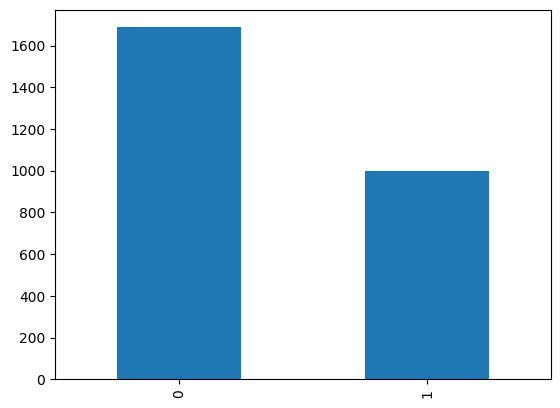

In [15]:
# lets explore some basic aspects of this dataset

spam['class'].value_counts().plot(kind= 'bar')

,word_freq_george,word_freq_you,word_freq_your,word_freq_hp,word_freq_free,word_freq_hpl,word_freq_our,word_freq_re,word_freq_edu,word_freq_remove,char_freq_!
class,,,,,,,,,,,
0,1.04,1.03,0.44,1.17,0.06,0.53,0.21,0.37,0.13,0.01,0.07
1,0.00,2.24,1.39,0.02,0.50,0.01,0.52,0.14,0.00,0.30,0.47


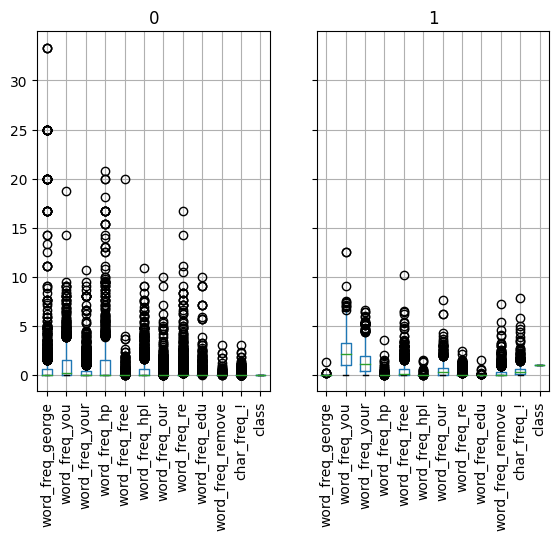

In [22]:
spam.groupby('class').boxplot(rot = 90)
spam.groupby('class').mean().round(2)

Do we see some structure? it seems that spam messages tend to contain _george_ less, and more of _free_ and _!_.
Based on these features, we could construct models to classify messages as _spam_ or _email_, or to predict the probability that a message is _spam_ or _email_. Clearly, these two problems are intimately related.

### Probabilistic classification using logistic regression

We will follow a very analogous route to regression. Recall that we were interested in minimizing the sum of squared residuals, and we saw that the *conditional mean* was the solution to our problem.

Note that, if $y \in \{0,1\}$, we have

$$ \mathbb E[y|X] = 1 \times P(y=1|X) + 0 \times P(y=0|X) = P(y=1 |X)$$

So, if we are interested in _probabilistic classification_ (as opposed to _classification_), our strategy will be very similar to that used in regression.

As before, there will be a learning function and we will take this function to be linear in parameters and features: 

$$ f(\bf x_i,\beta) = \bf{F}_i'\beta$$

However, now we have that $y \in \{0,1\}$, and our linear function may predict values that are outside this range.
We need a transformation that maps values on $\mathbb{R}$ to $[0,1]$. The *logistic function* is one option and leads to the **logistic regression**:

\begin{equation}
\log\frac{P(y_i=1|{\bf x}_i)}{P(y_i=0|{\bf x}_i)} = \beta_0 + {\bf x}_i'\beta
\end{equation}

Exponentiating the *log-odds* and noting that $P(y_i=0|{\bf x}_i)=1-P(y_i=1|{\bf x}_i)$, we can write

$$ P(y_i=1|{\bf x}_i) = \frac{ \exp({\beta_0 + {\bf x}_i'\beta})}{ 1 + \exp({\beta_0 + {\bf x}_i'\beta})} \hspace{1em} \text{  and  } \hspace{1em}  P(y_i=0|{\bf x}_i) = \frac{1}{ 1 + \exp({\beta_0 + {\bf x}_i'\beta})}$$ 

Note that these probabilities add up to one, as they should.
The plot below illustrates the logistic function.


<img src="https://github.com/barcelonagse-datascience/academic_files/raw/master/images/480px-Logistic-curve.png">

This type of models fall under the umbrella of **generalized linear models**. These models take the learning function to be linear in the parameters, and apply a transformation, described by a *link* function, to its output. In our case, the logistic function is the link, but this is by no means the only possible alternative.


Lets see how this works in practice to the spam dataset. For the moment we will use the original variables as features.

Here we focus on predictive modelling and the `sklearn.linear_model.LogisticRegression` is reasonable. This function actually optimizes over a penalized likelihood loss function by default. We will override this for now.

In [25]:
spam['class']

0       1
1       1
2       1
3       1
4       1
       ..
2681    0
2682    0
2683    0
2684    0
2685    0
Name: class, Length: 2686, dtype: int64

In [27]:
X = spam.drop('class', axis = 1)
y = spam['class']

freature_name = X.columns
class_label = ['email', 'spam'] 

In [29]:
# import the relevant sklearn tools
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty = 'none',
                           fit_intercept = True)

# fit logistic regression
logit.fit(X, y)

# compute the predicted probabilities in-sample
fitted_value = logit.predict_proba(X)
pd.DataFrame(fitted_value.round(3)).head(10) # see the output

,0,1
0,0.104,0.896
1,0.149,0.851
2,0.334,0.666
3,0.231,0.769
4,0.232,0.768
5,0.688,0.312
6,0.137,0.863
7,0.686,0.314
8,0.253,0.747
9,0.261,0.739


In [38]:
# copy our data and add a colum with our predictions
data_pred = spam.copy()

# the second column is the prob of spam
data_pred['p_i'] = fitted_value[:, 1]
data_pred[{'class', 'p_i'}].head(10)

C:\Users\wangc\AppData\Local\Temp\ipykernel_31028\4247039493.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_pred[{'class', 'p_i'}].head(10)


,p_i,class
0,0.896086,1
1,0.851184,1
2,0.666203,1
3,0.768990,1
4,0.767930,1
5,0.312270,1
6,0.863059,1
7,0.314138,1
8,0.747252,1
9,0.739172,1


<AxesSubplot: title={'center': 'p_i'}, xlabel='class'>

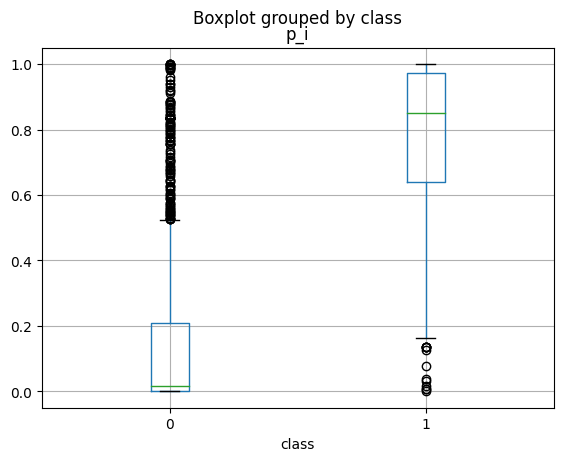

In [39]:
# see the boxplot
data_pred.boxplot(column = 'p_i', by = 'class')

### Turning probabilities into class prediction

The *probabilistic classifier* we use explicitly accounts for misclassification errors. The algorithm returns probabilities and these also reflect, to some extent, classification uncertainty.

Recall that if $y \sim Bernoulli(p)$ then $Var(y) = p (1- p)$, which is maximized at $p = 1/2$.

In  general, we may be interested in turning class probabilities into class prediction, e.g., to report medical tests (covid/no covid) -- the spam example is also a good example: a decision has to be taken for each email and it is convenient to have the algorithm produce class predictions. We will denote those by $\hat y_i$

With class prediction there will be **misclassification errors**: false positives and false negatives

Before we go into details, lets see what the default operations in `sklearn` do for us. We can compute the following quantities in or out of sample and cross-validated too - our previous discussion about the use of sample for evaluation applies here too. For the moment we experiment with in-sample calculations

In [40]:
# this is the predict method in the LogisticRegression object
y_hat = logit.predict(X)
# note that this is very different from predict_proba()

data_pred['y_hat'] = y_hat
print(data_pred.iloc[0:15,-3:])

    class       p_i  y_hat
0       1  0.896086      1
1       1  0.851184      1
2       1  0.666203      1
3       1  0.768990      1
4       1  0.767930      1
5       1  0.312270      0
6       1  0.863059      1
7       1  0.314138      0
8       1  0.747252      1
9       1  0.739172      1
10      1  0.976250      1
11      1  0.871072      1
12      1  0.905931      1
13      1  0.900436      1
14      1  0.999671      1


The predict function _classifies_ $\hat y$ as the most likely class. Hence, in our case, $p_i > 0.5 \Rightarrow \hat y =1$.

There is a number of accuracy measures for classifiers. In particular, we may be interested in answering questions like: _how many spam messages are correctly classified as spam_, _how many emails are classified as spam_, etc...

The confusion matrix tells us just that. 

c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


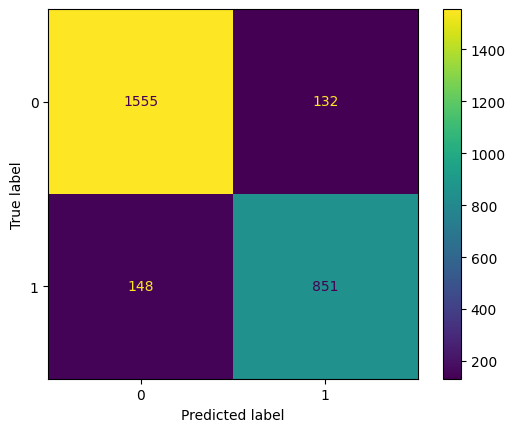

In [47]:
# confusion matrix
cm = metrics.plot_confusion_matrix(logit,
                                   X,
                                   y,
                                   values_format = '.0f')
plt.show()

c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


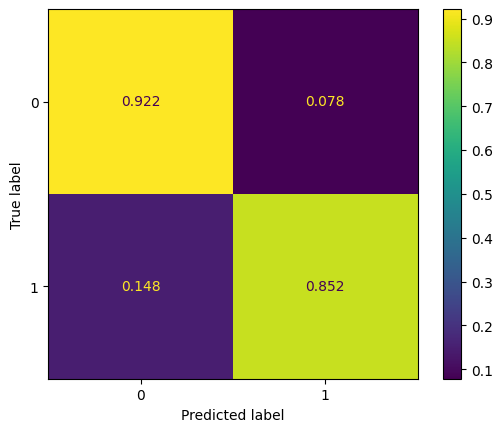

In [46]:
cm_normalized = metrics.plot_confusion_matrix(logit,
                                              X,
                                              y,
                                              normalize = 'true',
                                              values_format = '.3f')
plt.show()

In [48]:
cm.confusion_matrix

array([[1555,  132],
       [ 148,  851]], dtype=int64)

Our confusion matrix tells us that we correctly classify  92% of emails and 85% of spam. 
However, we wrongly classify 8% of our emails as spam, and 15% of spams as emails.

Depending on the application the losses can be very different (remember the medical example). Let 

$$L(true,predict)$$ 

be a loss function that computes the cost of misclassification - this is something that requires context information, which is typically not in the data. We take 

$$L(0,0) = L(1,1) = 0 \quad L(1,0) > 0 \quad L(0,1) > 0$$

Little math shows that if $L(1,0)/L(0,1) = C$ the optimal decision is: 

$$\hat y_i = 1 \iff p_i > {1 \over 1+C}$$

Clearly, we have so far taken $C=1$. But we could do it differently. For instance, say that we take $C=1/2$, that is: the price we pay for wrongly classifying an email as spam is twice that of wrongly classifying a spam as email. What happens to our classifier in this case?

array([[0.94902193, 0.05097807],
       [0.27927928, 0.72072072]])

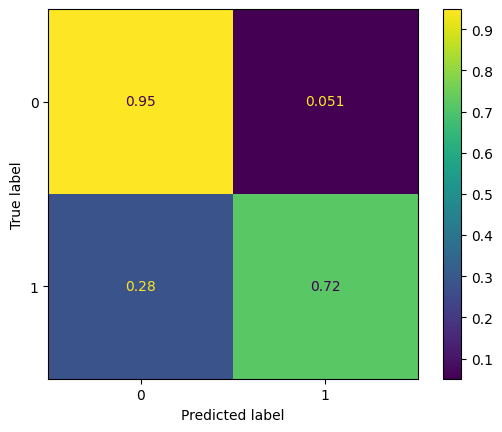

In [54]:
y_hat_new = np.ones(y.size)
y_hat_new[fitted_value[:,1] < 0.66] = 0

cm = metrics.confusion_matrix(y_pred = y_hat_new,
                              y_true = y,
                              normalize = 'true')

# plot confusion matrix
metrics.ConfusionMatrixDisplay(cm).plot()# Plotting confusion matrix 

cm

Now we only classify as spam 5% of our emails, as opposed to 8% before. But this comes at a cost: we reduce our classification rate for spam messages, wrongly classifying 28% of spam messages as emails.

As we vary the _decision boundary_, we get what is known as the ROC curve.

### ROC curve and AUC

The ROC (Receiver Operating Characteristic) curve is a common tool to assess the performance of a probabilistic classifier. Each point on this curve is an estimate of the pair

$$
( p([\hat y =1 | y = 1]), p([\hat y = 1 | y = 0]) )  = ( \text{True Positive Rate} , \text{False Positive Rate})
$$

For a given threshold $t$ we can estimate these probabilities from the confusion matrix - obtained in the best way we can - simply by computing the associated frequencies.

As we vary the threshold the confusion matrices change and the frequencies too: varying $t$ from 0 to 1 we obtain the ROC curve.


#### AUC

The AUC is the Area Under (the ROC) Curve

It has though an interesting and solid statistical interpretation. It can be directly related to a non-parametric test - the **Mann-Whitney** test that the following two samples come from the same distribution: 

$$
\textrm{class 1 probs }: \{p_i: y_i = 1\} \quad \textrm{class 0 probs }: \{p_i: y_i = 0\}
$$

You would expect that for a decent classifier the two samples come from different distributions and the distribution of the "class 1 probs" is stochastically greater. If the two distributions were identical we would obtain the red-dashed ROC curve.

Consider a contest between the two samples:  each element of the first we compare with all of the elements in the second and record how many times it was at least as big. AUC is the frequency of won contests!

A perfect classifier would have (TPR=1,FPR=0) and an AUC of 1.


In our example, we have

In [61]:
pd.DataFrame(fitted_value.round(3)).head(10)


,0,1
0,0.104,0.896
1,0.149,0.851
2,0.334,0.666
3,0.231,0.769
4,0.232,0.768
5,0.688,0.312
6,0.137,0.863
7,0.686,0.314
8,0.253,0.747
9,0.261,0.739


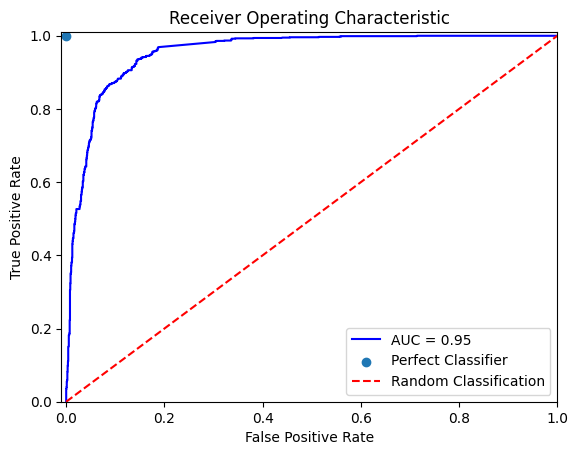

In [68]:
fpr, tpr, threshold = metrics.roc_curve(y,
                                        fitted_value[:,1])

roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.scatter(0, 1, label = 'Perfect Classifier')
plt.plot([0, 1], [0, 1], 'r--', label = 'Random Classification')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Misclassification rate

The probability 

$$p[ y \neq \hat y]$$ 

is known as the misclassification probability. This can be estimated from data very much the same way as the $R^2$: in sample and out of sample (by cross-validation, etc).

This number in isolation has little meaning. Consider as an example the case where we wish to predict $y$ in a population such that $p[y=1] = 0.001$. Then classifying everyone as $\hat y = 0$ yields a misclassification probability 0.001 but the algorithm is never able to identify the class of interest. Misclassification rate can be useful when comparising algorithms in the same dataset. 

There are a number of additional performance metrics related to the conditional probabilities - e.g. $p[\hat y =1 | y=1]$ etc - such as specificity/sensitivity for qualifying the performance of a classifier.

### Class imbalance

### Context

We may want to predict the incidence of a rare event:  rare disease, an accident, a default, exceptional performance, etc, on the basis of measured characteristics. 

Naturally, our data will have very little representation of the class we are particularly interested in. Hence it will be hard to learn the function that separates "rare" from "common" on the basis of the measured characteristics; indeed classifiers will not mind overpredicting the "common". 

Lets look at an example

### Can we predict good wine ? 

This is another standard dataset available from the UCI repository. It is really about **ordinal regression** - or maybe **multiclass classification**. Here we will for illustration consider (at the expense of losing information) a transformation of the response.

We are interested in predicting wine _quality_ on the basis of its characteristics.


In [69]:
wine_df = pd.read_csv('https://github.com/barcelonagse-datascience/academic_files/raw/master/data/wine.csv')
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


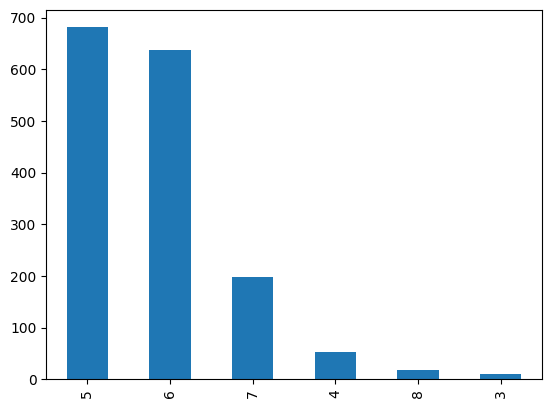

In [72]:
wine_df['quality'].value_counts().plot(kind = 'bar')
plt.show()

0    1581
1      18
Name: high_quality, dtype: int64


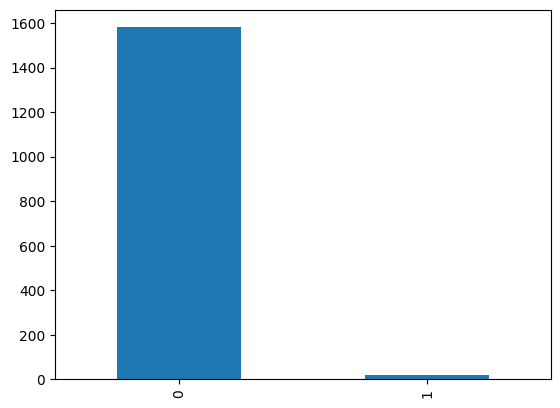

In [75]:
wine_df['high_quality'] = [1 if i >= 8 else 0 for i in wine_df['quality']]

wine_df['high_quality'].value_counts().plot(kind = 'bar')
print(wine_df['high_quality'].value_counts())

Classes are highly imbalanced

In [76]:
# prepare the data
X = wine_df.drop(['high_quality', 'quality'], axis = 1)

y = wine_df['high_quality']

In [77]:
from sklearn.model_selection import cross_val_predict

# here we use a different solver. In fact, this is L2 penalized logistic regression
model = LogisticRegression(C = 100,
                           solver = 'liblinear')

# see the help file for more details

y_pred = cross_val_predict(model,
                           X,
                           y,
                           cv = 5)

model.fit(X, y)
y_prob = model.predict_proba(X)
wine_df['p_i'] = y_prob[:, 1]
pd.DataFrame(y_prob).head().round(3)

,0,1
0,1.000,0.000
1,0.999,0.001
2,0.999,0.001
3,0.999,0.001
4,1.000,0.000


In [79]:
# lets look at the AUC and ROC
y_probabilities = cross_val_predict(model,
                                    X,
                                    y,
                                    method = 'predict_proba',
                                    cv = 5)

fpr, tpr, threshold = metrics.roc_curve(y,
                                        y_probabilities[:, 1])
roc_auc = metrics.auc(fpr, tpr)

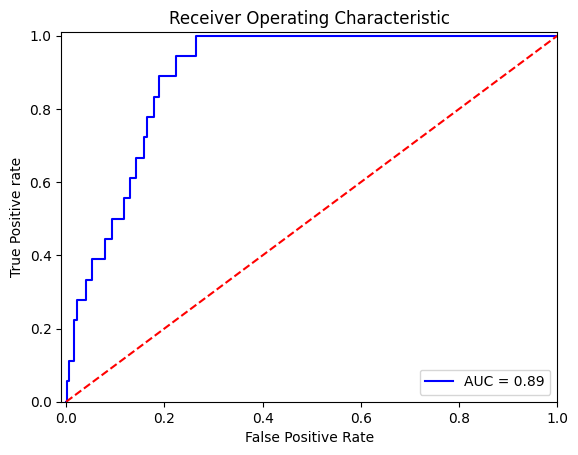

In [89]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,
         tpr,
         'b',
         label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive rate')
plt.xlabel('False Positive Rate')
plt.show()

In [92]:
print(pd.DataFrame(y_prob).head())
print(pd.DataFrame(y_probabilities).head())

          0         1
0  0.999813  0.000187
1  0.998969  0.001031
2  0.999128  0.000872
3  0.999143  0.000857
4  0.999813  0.000187
          0         1
0  0.999846  0.000154
1  0.999111  0.000889
2  0.999287  0.000713
3  0.998930  0.001070
4  0.999846  0.000154


In [94]:
# accuracy
print('Accuracy (cross-validated): ', metrics.accuracy_score(y, y_pred))

# classification report
print(metrics.classification_report(y, y_pred))

Accuracy (cross-validated):  0.9868667917448405
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1581
           1       0.00      0.00      0.00        18

    accuracy                           0.99      1599
   macro avg       0.49      0.50      0.50      1599
weighted avg       0.98      0.99      0.98      1599



c:\Users\wangc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


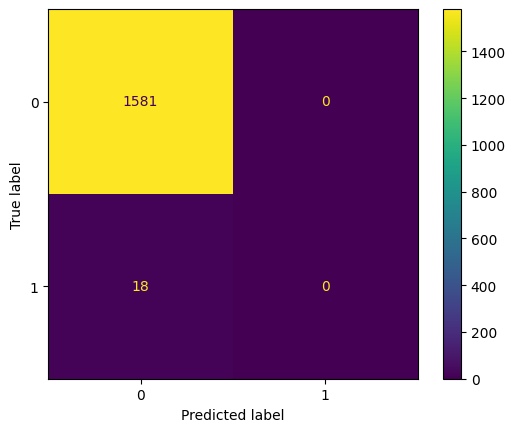

In [98]:
# confusion matrix
cm = metrics.plot_confusion_matrix(model,
                                   X,
                                   y,
                                   values_format = '.0f')

**The 18 high quality wines are all misclassified by our classifier.**

### Some approaches to class imbalance

Roughly speaking there are two ways to tackle the class imbalance issue: 

+  Think carefully about how to sample the data. We may be interested in sampling more from the characteristics we care about (Retrospective studies).

+ Resampling and use of _synthetic_ data: this works with the data at hand

### Retrospective studies

Collect data not as a *representative* sample from the population of interest, but oversample the rare class; for example from our wine database we could choose a sample of $n/2$ high quality wines and $n/2$ not high quality.

On the basis of this *biased (non-representative)* sample train a probabilistic classifier, e.g., logistic regression 

The estimated learning function is biased too - it will predict way larger probability of class=1, but this bias is in the direction that we would like it to be.

### Resampling approaches

Having no control of the data collection protocol, we can try and sharpen the distinction between the two classes by either under-representing (*undersampling*) the popular class, or over-representing (*oversampling*) the rare class, or both.

Oversampling might just be randomly replicating rare cases or creating synthetic rare cases that "look like" the rare cases in the sample. To this respect doing some modelling on the $\bf x_i$ s can help - and there are links to *Bayes classifiers* we mention later. For example SMOTE (Synthetic Minority Oversampling Technique) does this.

Some tools in `sklearn` to do this are, e.g., the module `imblearn` and its methods `.over_sampling`, e.g. `RandomOverSampler` and `SMOTE`. `imblearn` requires installing - do not do this now! Analogous result to `.over_sampling` is obtained using `LogisticRegression`  `class_weight="balanced"` argument, that corresponds to oversampling

In our wine prediction example we have also done some arbitrary dichotomization of the response: no good reason why we should not pay for it!!

Lets try our fixes on the wine data:

In [100]:
model = LogisticRegression(C = 100, 
                           class_weight = 'balanced',
                           solver = 'liblinear')

model.fit(X, y)
fitted_value_imb = model.predict_proba(X)
wine_df['imbp_i'] = fitted_value_imb[:, 1]
wine_df[['high_quality', 'imbp_i', 'p_i']].groupby('high_quality').mean()

,imbp_i,p_i
high_quality,,
0,0.162044,0.010524
1,0.837867,0.075301


Note that these are not proper estimates of the class probability: we need to correct for the biased sample by rescaling the predicted probability 

In [126]:
# the correction factor
q1 = np.mean(y)
r1 = 0.5

def reweight(pi, q1, r1):
  r0 = 1 - r1
  q0 = 1 - q1
  tot = pi*(q1/r1) + (1-pi)*(q0/r0)
  w = pi*(q1/r1)
  w /= tot
  return w

Note that if `pi=0`, `w=0`. Also, if `pi=1`, `w=1`. Next, if `pi=0.5`, `w=q1` meaning we predict with the unconditional probability of the rare class.

In [110]:
rr = np.linspace(0, 1, 1000)
q1 # the unconditional probability of y==1

0.01125703564727955

In [127]:
reweight(0.5, 0.5, 0.5), reweight(0.5, 0.3, 0.5), reweight(0.5, 0.1, 0.5)

(0.5, 0.3, 0.1)

In [128]:
reweight(0.75,0.5,0.5), reweight(0.75,0.3,0.5), reweight(0.75,0.1,0.5)

(0.75, 0.5625, 0.25)

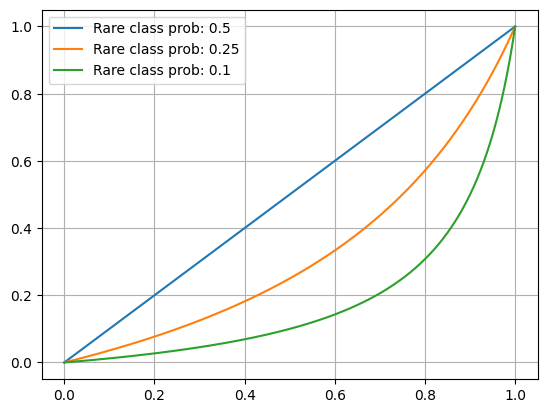

In [131]:
plt.subplots
plt.plot(rr, 
         reweight(rr, 0.5, r1),
         label = ('Rare class prob: %s' % 0.5))
plt.plot(rr,
         reweight(rr, 0.25, r1),
         label = ('Rare class prob: %s' % 0.25))
plt.plot(rr,
         reweight(rr, 0.1, r1),
         label = ('Rare class prob: %s' % 0.1))
plt.legend()
plt.grid()

In [133]:
#  correct for biased sample
wine_df['imbp_corr'] = wine_df['imbp_i'].apply(reweight, args=(q1,r1))

wine_df[['high_quality', 'imbp_corr', 'imbp_i', 'p_i']].groupby('high_quality').mean()

,imbp_corr,imbp_i,p_i
high_quality,,,
0,0.016864,0.162044,0.010524
1,0.147471,0.837867,0.075301


array([<AxesSubplot: title={'center': 'p_i'}, xlabel='quality'>,
       <AxesSubplot: title={'center': 'imbp_i'}, xlabel='quality'>,
       <AxesSubplot: title={'center': 'imbp_corr'}, xlabel='quality'>],
      dtype=object)

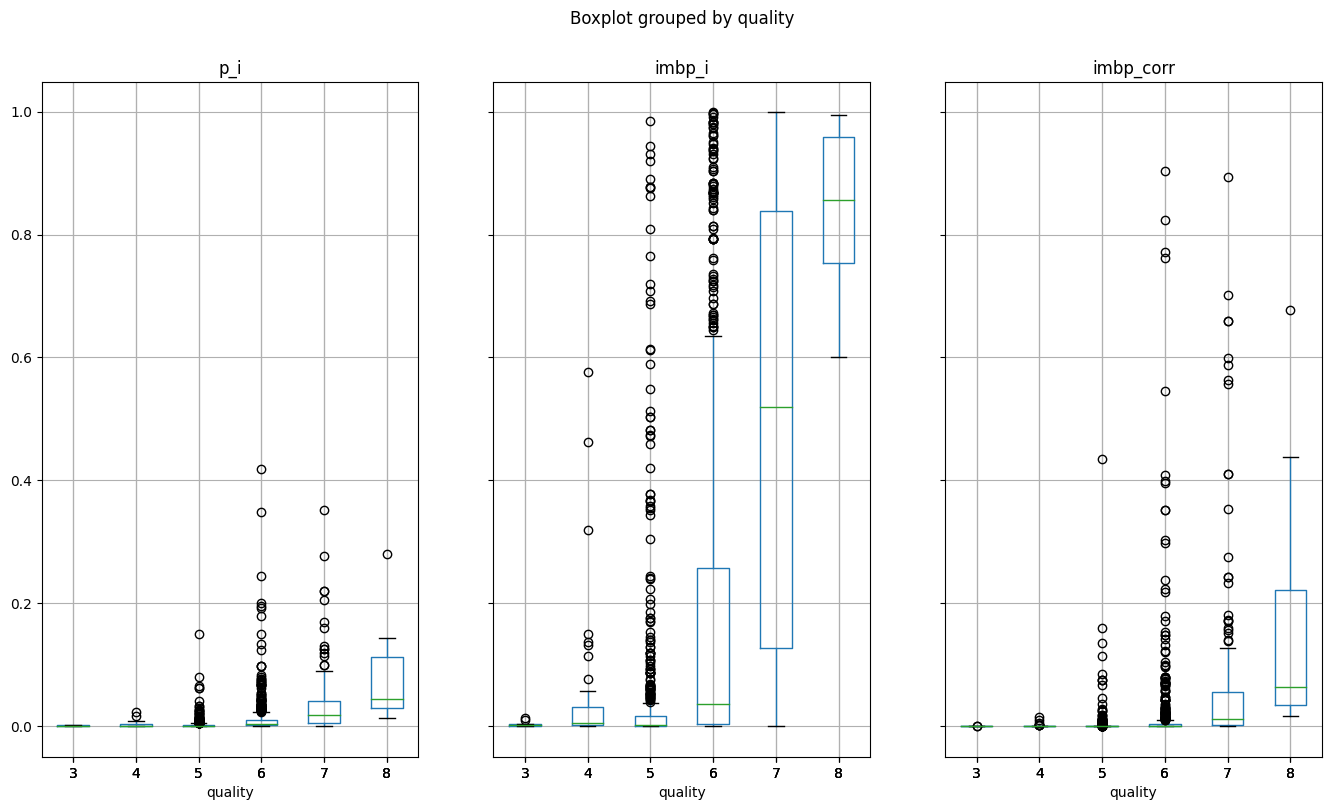

In [134]:
wine_df.boxplot(['p_i', 'imbp_i', 'imbp_corr'],
                by='quality', 
                layout = (1, 3),
                figsize = (16, 9))


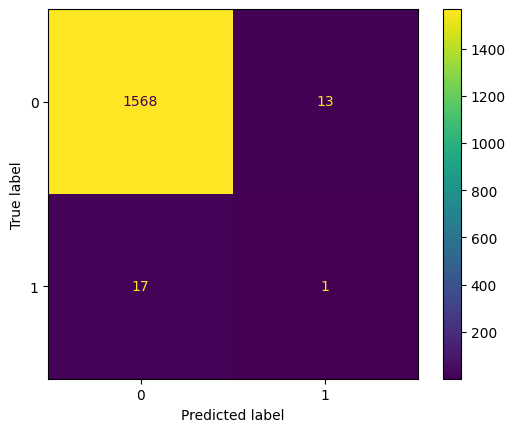

In [137]:
y_pred_imb = [1 if pi >= 0.5 else 0 for pi in wine_df['imbp_corr']]

# consusion matrix
cm = metrics.confusion_matrix(y_pred = y_pred_imb,
                              y_true = y,
                              labels = [0, 1])

cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

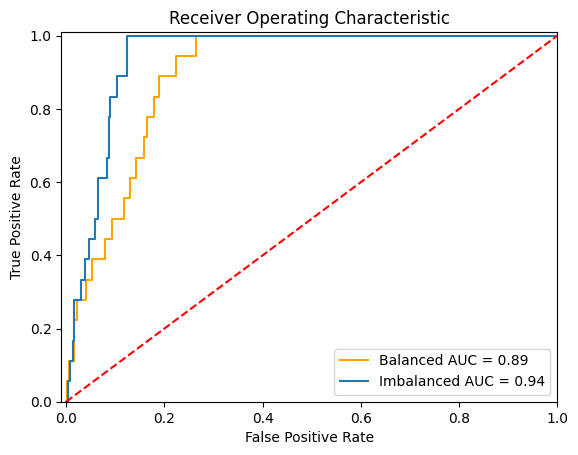

In [151]:
fpr_imb, tpr_imb, threshold_imb = metrics.roc_curve(y,
                                                    wine_df['imbp_corr'])
roc_auc_imb = metrics.auc(fpr_imb, tpr_imb)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'orange', label = 'Balanced AUC = %0.2f' % roc_auc)
plt.plot(fpr_imb, tpr_imb, label = "Imbalanced AUC = %0.2f" % roc_auc_imb)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

### Regularization

Everything that applies to regression applies to logistic regression: ridge, lasso etc penalties can be used for high-dimensional feature spaces and when they are convex the resultant loss function is too and the algorithms are efficient 

Indeed, the `LogisticRegression` function by default includes the ridge penalty.

### Multiclass classification

Often the output variable is categorical with many options, not just two, e.g. the wine dataset. 

It is more convenient to encode such multiclass output using dummy variables, i.e., each output is a vector of 0s with a single 1 in the chosen class: 

$$\bf y_i = (y_{i1},\ldots,y_{iK})' \quad y_{ij} \in \{0,1\}, \quad \sum_j y_{ij} = 1$$


where the labels $1,2,\ldots,K$ are indexes for the different output categories and any sensible analysis should not depends on their values. 

Binary classification takes $K=2$. In fact, in modern applications we can have $K \sim 100$ or even $K \sim 1000$ (e.g. *recommendation*).

The most direct extension of the binary regression to multiclass is as follows. We take

$$\bf y_i \sim Categorical(\pi_{i1},\ldots,\pi_{iK})$$

with density 

$$p(\bf y_i) = \prod_{j} \pi_{ij}^{y_{ij}}$$

which is a clever way to simply say that the probability that the $j$ th category is chosen is $\pi_{ij}$. 

### Multinomial-logistic regression

We need to map the probabilities $\pi_{ij}$ to the input $\bf x_i$. One way that collapses to logistic regression when $K=2$ is to take:

$$\log{\pi_{ij} \over \pi_{i1}} = f(\bf x_i,\beta_j)$$

Note that implicit in this definition is that the odds to choose $j$ vs 1 do not depend on what other options there exist: this is known as the *independence of irrelevant alternatives* assumptions and is criticized in certain contexts. 

The model definition implies

$$\pi_{ij} = {e^{f(\bf x_i,\beta_j)} \over 1+ \sum_{k>1} e^{f(\bf x_i,\beta_k)}}$$

and you should check that for $K=2$ this is precisely logistic regression. The pivot category is taken above to be 1, but any other can be chosen - this only affects the interpretation of the results. Note also that we have different parameters $\beta_j$ for each category $j$. 

This model is known by a multitude of names...

https://en.wikipedia.org/wiki/Multinomial_logistic_regression

The negative log-likelihood is immediatelly obtained and is **convex** in the $\beta_j$ s, hence we have a nice learning problem to solve. In fact, an old clever trick can be used to turn learning this model into a Poisson GLM, this is known as the *Poisson trick* in the Stats community. This is particularly clever for large $K$ and is being reinvented (again..) by the ML community

### Reanalyzing the wine data

`LogisticRegression` in `sklearn` does in fact also fit the multinomial-logistic regression model. Lets try this out

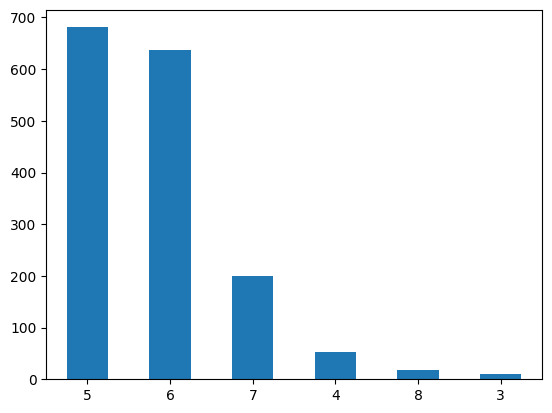

In [155]:
# multinomial-logistic regression for wine, lets start from scrath
wine_df = pd.read_csv('https://github.com/barcelonagse-datascience/academic_files/raw/master/data/wine.csv')

model = LogisticRegression(C = 100, multi_class = 'multinomial',
                           solver = 'newton-cg',
                           max_iter = 10000)

X = wine_df.drop(['quality'], axis = 1)
y = wine_df['quality']
model.fit(X, y)
wine_df['quality'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.show()

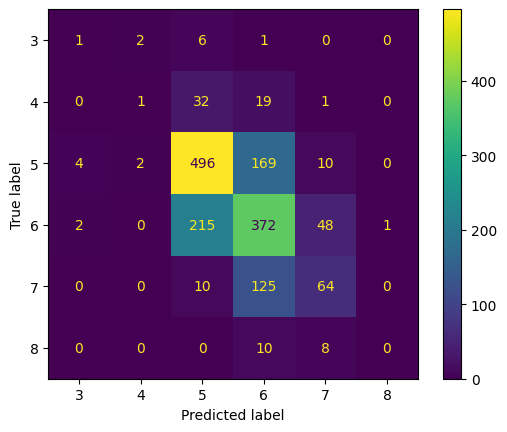

In [160]:
y_probabilities = cross_val_predict(model,
                                    X,
                                    y,
                                    method = 'predict_proba',
                                    cv = 5)

y_class = cross_val_predict(model, X, y, cv = 5)

cm = metrics.confusion_matrix(y_pred = y_class,
                              y_true = y,
                              labels = [3,4,5,6,7,8])

cm_display = metrics.ConfusionMatrixDisplay(cm.round(3),
                                            display_labels = [3,4,5,6,7,8]).plot()

### Some hints for practitioners

+ Predictive modelling with categorical output can be done using `LogisticRegression`; by default this module includes regularization, hence it is straighforward to include hundreds of features
+ When the output is multicategorical its way more sensible to build directly a model for the original output than first turn it (more or less arbitrarily) into a binary output. Even if for commercial/interpretability purposes a binary prediction is preferred, its preferrable to turn the multicategorical prediction into binary rather than the multicategorical output to binary and build a model
+ A probabilistic classifier returns probabilities for the possible categories. It is not exclusively the data scientist's job to turn those into class predictions. This should be done in conjunction with the user of the analysis and the consideration of losses. Once the losses have been specified a simple formula gives the optimal conversion
+ Class imbalance is an issue relevant for many or even most classification applications. Using the `class_weight="balanced"` within `LogisticRegression` gives a possible improvement using oversampling - make sure to correct the probabilities it returns since they are not correct!